### Colab_Version

In [2]:
# 安装必要依赖（只需首次运行）
!pip install osmnx geopandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.3/101.3 kB 7.7 MB/s eta 0:00:00


In [21]:
import os
import re
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

BoroughShp
city_of_london_bike_accessible_roads.geojson
COL_cycleavailable.geojson
COL_cyclelane.geojson
Env
greater_london_bike_accessible_roads.geojson
GreatLondonShp
Roads
Slope


In [7]:
edges = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/Roads/edges_final.gpkg")
print(edges.columns)

Index(['u', 'v', 'key', 'osmid', 'access', 'highway', 'maxspeed', 'name',
       'oneway', 'reversed', 'length', 'lanes', 'ref', 'bridge', 'junction',
       'tunnel', 'width', 'service', 'est_width', 'area', 'geometry'],
      dtype='object')


In [25]:
# 构造 LTS 所需字段
# 1
edges['functional_class'] = edges['highway']

# 2
# 判断 highway 字段中是否含有 'cycleway'，支持字符串和列表两种情况
def detect_bike_lane(value):
    if isinstance(value, list):
        return 'cycleway' in value
    elif isinstance(value, str):
        return value == 'cycleway'
    return False

edges['has_bike_lane'] = edges['highway'].apply(detect_bike_lane)

# 3
def extract_min_speed(val):
    if isinstance(val, list):
        speeds = [int(re.findall(r'\d+', s)[0]) for s in val if re.findall(r'\d+', s)]
        return min(speeds) if speeds else None
    elif isinstance(val, str):
        matches = re.findall(r'\d+', val)
        return int(min(matches)) if matches else None
    return None

# 如果是字符串形式的列表（比如 "['30 mph', '20 mph']"），先 eval 一下
edges['maxspeed_clean'] = edges['maxspeed'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x)

# 提取最小 mph 数字，NaN 填 30（默认值）
edges['speed_limit'] = edges['maxspeed_clean'].apply(extract_min_speed).fillna(30)


# 4
edges['lane_count'] = pd.to_numeric(edges['lanes'], errors='coerce').fillna(1)

#定义简化版 LTS 判定规则
def assign_lts(row):
    fc = row['functional_class']
    bike = row['has_bike_lane']
    speed = row['speed_limit']
    lanes = row['lane_count']

    if isinstance(fc, list): fc = fc[0]
    if pd.isna(fc): fc = 'unclassified'

    if bike and speed <= 25 and lanes <= 2 and fc in ['residential', 'unclassified', 'living_street']:
    # if bike and speed <= 25 and lanes <= 2:
        return 1
    if (not bike and speed <= 30 and lanes <= 2) or (bike and speed <= 35 and lanes <= 3):
        if fc in ['residential', 'tertiary', 'unclassified']:
            return 2
    if (speed > 35 and lanes <= 2) or (not bike and lanes == 3):
        if fc in ['tertiary', 'secondary']:
            return 3
    if speed > 50 or lanes >= 4 or (not bike and fc in ['primary', 'trunk', 'motorway']):
        return 4
    return 3

#执行 LTS 分类
edges['LTS'] = edges.apply(assign_lts, axis=1)

In [14]:
edges['functional_class'].value_counts()

,count
functional_class,
residential,104949
service,38530
primary,22748
tertiary,21565
cycleway,12404
...,...
"['unclassified', 'primary']",1
"['unclassified', 'residential', 'service', 'path']",1
"['secondary', 'cycleway']",1


In [19]:
edges['has_bike_lane'].value_counts()

,count
has_bike_lane,
False,235662
True,12404


In [23]:
edges['speed_limit'].value_counts()

,count
speed_limit,
30.0,134703
20.0,106842
40.0,3357
5.0,989
50.0,856
10.0,854
15.0,247
60.0,96
70.0,60


In [17]:
edges['lane_count'].value_counts()

,count
lane_count,
1.0,210185
2.0,32578
3.0,3784
4.0,1317
5.0,147
6.0,38
1.5,9
0.0,4
11.0,2


In [27]:
edges['LTS'].value_counts()

,count
LTS,
2,137539
3,79115
4,31112
1,300


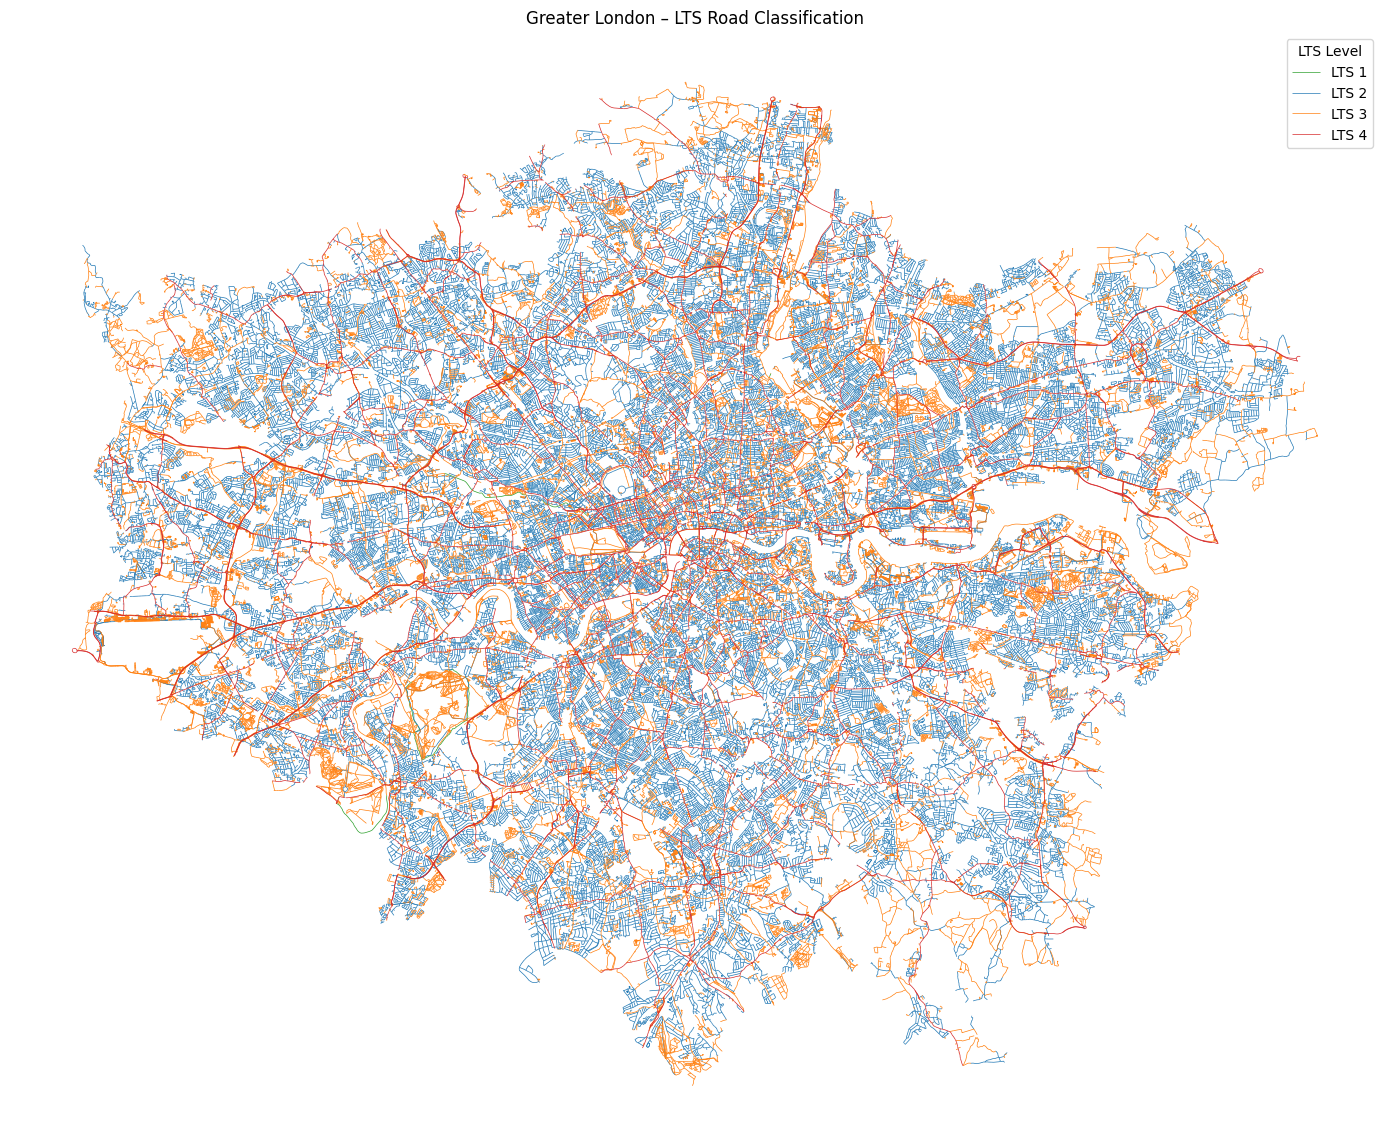

In [26]:
# 确保 LTS 字段为整数（防止 float 比较错误）
edges['LTS'] = edges['LTS'].astype('Int64')

# 绘图：不同 LTS 等级上色
lts_colors = {1: '#2ca02c', 2: '#1f77b4', 3: '#ff7f0e', 4: '#d62728'}

fig, ax = plt.subplots(figsize=(14, 14))
for level, color in lts_colors.items():
    subset = edges[edges['LTS'] == level]
    if not subset.empty:
        subset.plot(ax=ax, color=color, linewidth=0.5, label=f'LTS {level}')

ax.legend(title='LTS Level')
ax.set_title('Greater London – LTS Road Classification')
ax.set_axis_off()
plt.tight_layout()
plt.show()